In [79]:
import random
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# for reproducability
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print("Random Seed:", manualSeed)

Random Seed: 999


In [60]:
# the path to the root of the dataset folder
dataroot = 'processed-celeba-small/processed_celeba_small/celeba/'
# the number of worker threads for loading the data with the DataLoader
workers = 2
# the batch size used in training. 128 from DCGAN paper
batch_size = 128
# the spatial size of the images used for training
image_size = 64
# number of color channels in the input images. For color images this is 3
nc = 3
#  length of latent vector z
nz = 100
# relates to the depth of feature maps carried through the generator
gconvf = 64
# relates to the depth of feature maps carried through the discriminator
dconvf = 64
# number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
num_epochs = 5
# learning rate for training. As described in the DCGAN paper, this number should be 0.0002
lr = 0.0002
# beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
beta1 = 0.5

In [61]:
def dataloader(data, batch_size, image_size, workers):
    # transforms
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # create dataset
    dataset = dsets.ImageFolder(
        root=data,
        transform=transform,
    )
    # create dataloader
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)
    
    return loader

In [62]:
imageloader = dataloader(dataroot, batch_size, image_size, workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


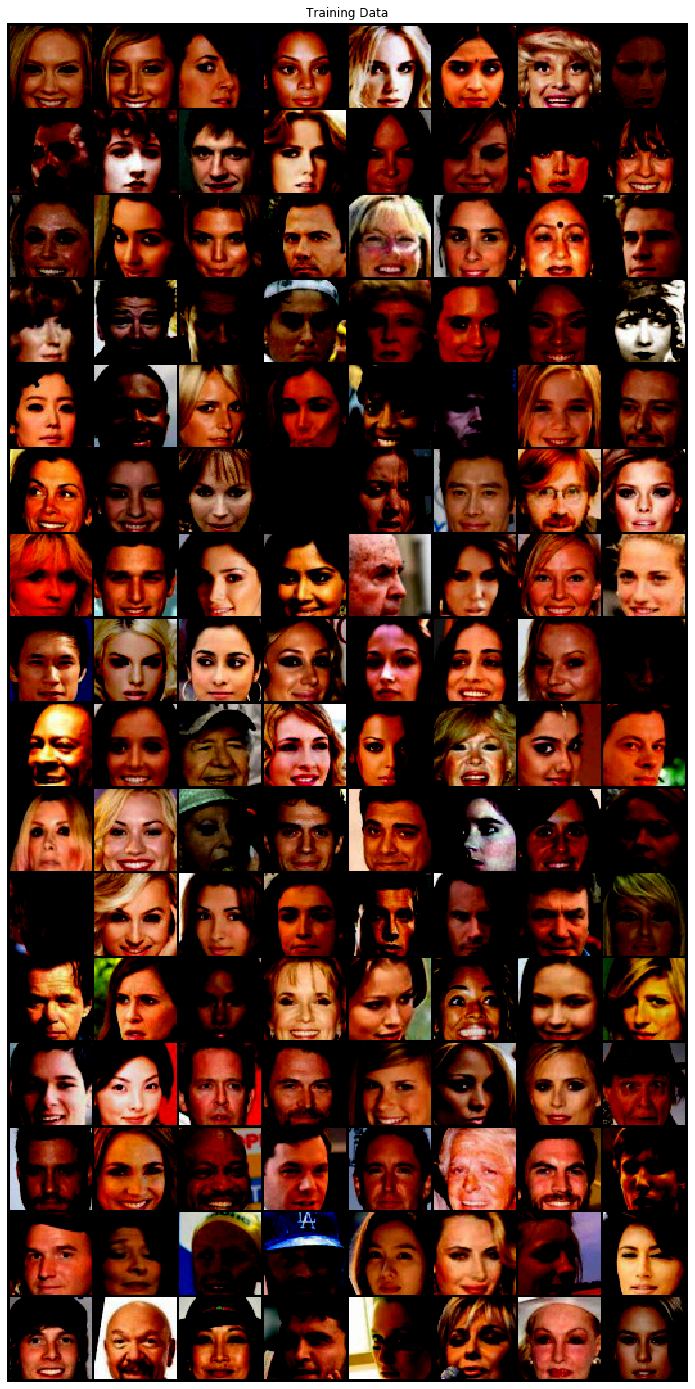

In [63]:
# visualizing real data
real_batch = next(iter(imageloader))
plt.figure(figsize=(25,25))
plt.axis("off")
plt.title("Training Data")
plt.imshow(np.transpose(utils.make_grid(real_batch[0], padding=2),(1,2,0)))

In [64]:
# weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [65]:
# Generator

def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            t_conv(nz, gconvf * 8, 4, 1, 0),
            nn.ReLU(True),
            # state size. (gconvf*8) x 4 x 4
            t_conv(gconvf * 8, gconvf * 4, 4),
            nn.ReLU(True),
            # state size. (gconvf*4) x 8 x 8
            t_conv(gconvf * 4, gconvf * 2, 4),
            nn.ReLU(True),
            # state size. (gconvf*2) x 16 x 16
            t_conv(gconvf * 2, gconvf, 4),
            nn.ReLU(),
            # state size. (gconvf) x 32 x 32
            t_conv(gconvf, nc, 4, batch_norm=False),
            nn.Tanh()
            # state size. (gconvf) x 64 x 64
        )
        
    def forward(self, x):
        return self.main(x)

In [66]:
# generator mode
G = Generator()
# initialize model weights
G.apply(weights_init)

print(G)

Generator(
  (main): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU(inplace=True)
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU(inplace=True)
    (4): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): ReLU(inplace=True)
    (6): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): ReLU()
    (8): 

In [72]:
# Discriminator

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers) 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            conv(nc, dconvf, 4, batch_norm=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dconvf) x 32 x 32
            conv(dconvf, dconvf * 2, 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dconvf * 2) x 16 x 16
            conv(dconvf * 2, dconvf * 4, 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dconvf * 4) x 8 x 8
            conv(dconvf * 4, gconvf * 8, 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (dconvf * 8) x 4 x 4
            conv(gconvf * 8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

In [73]:
# generator mode
D = Discriminator()
# initialize model weights
D.apply(weights_init)

print(D)

Discriminator(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8)

In [74]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


In [75]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1)

if train_on_gpu:
    fixed_noise = fixed_noise.cuda()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [82]:
# Training Loop
if train_on_gpu:
    D.cuda()
    G.cuda()

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (real_images, _) in enumerate(imageloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        optimizerD.zero_grad()
        # Format batch
        b_size = real_images.size(0)
        label = torch.full((b_size,), real_label)
        if train_on_gpu:
                real_images = real_images.cuda()
                label = label.cuda()
        # Forward pass real batch through D
        output = D(real_images)
        # Calculate loss on all-real batch
        errD_real = criterion(output.squeeze(), label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1)
        if train_on_gpu:
            noise = noise.cuda()
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach())
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output.squeeze(), label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake)
        # Calculate G's loss based on this output
        errG = criterion(output.squeeze(), label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(imageloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(imageloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/448]	Loss_D: 1.4611	Loss_G: 0.6954	D(x): 0.4987	D(G(z)): 0.5007 / 0.5006


KeyboardInterrupt: 

In [ ]:
# losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# visualizing G
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())